<a href="https://colab.research.google.com/github/Shashank-Holla/DepthEstimation-MaskPrediction/blob/master/main_mask_depth_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Check the GPU

In [0]:
!nvidia-smi

Sat May 30 15:07:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Mount drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


## Import Packages 

In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
!pip install -q -U git+https://github.com/albu/albumentations
!pip install -q kornia
from kornia.losses import SSIM
import autoreload

import cv2
import glob
import numpy as np
from tqdm.autonotebook import tqdm, trange
import time
import shutil
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR


     |████████████████████████████████| 634kB 4.7MB/s 
     |████████████████████████████████| 163kB 4.8MB/s 


### Import Modules

In [0]:
cd '/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_Depth_Predictor/'

/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_Depth_Predictor


In [0]:
from data import *
from metrics import *
from models import *
from train import train
from test import test
import loss

Albumentations version: 0.4.5


In [0]:
%reload_ext autoreload
%autoreload

In [0]:
cd /content

/content


In [0]:
ls

sample_data/


Use CUDNN benchmark for optimization

In [0]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

### Path configuration

In [0]:
gdrive_path = '/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth'
data_root = './data'
if  not os.path.exists("model_save"):
    os.mkdir("model_save")

model_save = './model_save'

## Datasetup

In [0]:
if not os.path.exists("data"):
    os.mkdir("data")
    # Copy bg, bg_fg and mask data folders inside data folder. Unzip bg_fg and mask
    shutil.copytree(os.path.join(gdrive_path,'bg'),os.path.join(data_root,'bg'))
    shutil.copy(os.path.join(gdrive_path,'bg_fg.zip'), data_root)
    !unzip -q data/bg_fg.zip -d data
    shutil.copy(os.path.join(gdrive_path,'mask.zip'), data_root)
    !unzip -q data/mask.zip -d data
    shutil.copy(os.path.join(gdrive_path,'depth.zip'), data_root)
    !unzip -q data/depth.zip -d data

In [0]:
ls data

bg/  bg_fg/  bg_fg.zip  depth/  depth.zip  mask/  mask.zip


In [0]:
if os.path.exists("data/bg_fg.zip"):
    os.remove('data/bg_fg.zip')
if os.path.exists("data/depth.zip"):
    os.remove('data/depth.zip')
if os.path.exists("data/mask.zip"):
    os.remove('data/mask.zip')   

In [0]:
ls data/bg_fg | wc -l

400000


In [0]:
ls data/mask | wc -l

400000


In [0]:
ls data/depth | wc -l

400000


## Create Dataset and Dataloader

In [0]:
images_mean = {"bg_images": [0.68968, 0.65092, 0.60790], "bg_fg_images" : [0.68084, 0.64135, 0.59833], "mask_images":[0.06140], "depth_images":[0.49981]}
images_std =  {"bg_images": [0.18897, 0.20892, 0.23450], "bg_fg_images" : [0.19432, 0.21262, 0.23641], "mask_images":[0.23733], "depth_images":[0.27300]}

In [0]:
train_dataset = schrodingersCatDataset(data_root, train=True, train_split=0.7, transform=True, target_transform=True, resize=(112,112))
test_dataset = schrodingersCatDataset(data_root, train=False, train_split=0.7, transform=True, target_transform=True, resize=(112,112))

params = {'batch_size': 128, 'shuffle': True, 'num_workers': 12, 'pin_memory':True}

train_loader = DataLoader(train_dataset, **params)
test_loader = DataLoader(test_dataset, **params)

input transforms applied
input transforms applied
target transforms applied
target transforms applied
input transforms applied
input transforms applied
target transforms applied
target transforms applied


In [0]:
train_dataset.__len__()

280000

In [0]:
test_dataset.__len__()

120000

### View data

In [0]:
img_dict = next(iter(train_loader))

In [0]:
bg_i = img_dict["bg_image"]
bg_fg_i = img_dict["bg_fg_image"]
mask_i = img_dict["mask_image"]
depth_i = img_dict["depth_image"]

In [0]:
bg_i = denormalize(bg_i, images_mean["bg_images"], images_std["bg_images"])
bg_fg_i = denormalize(bg_fg_i, images_mean["bg_fg_images"], images_std["bg_fg_images"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


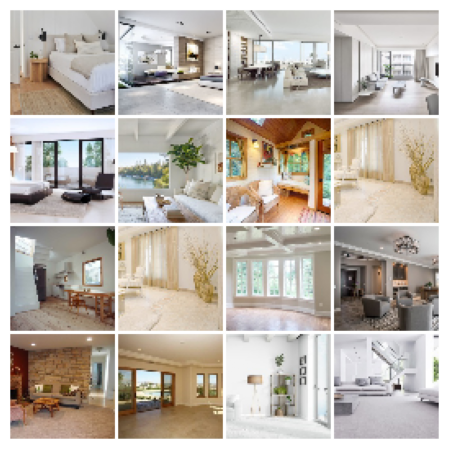

In [0]:
image_show(bg_i[:16], figsize = (8,8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


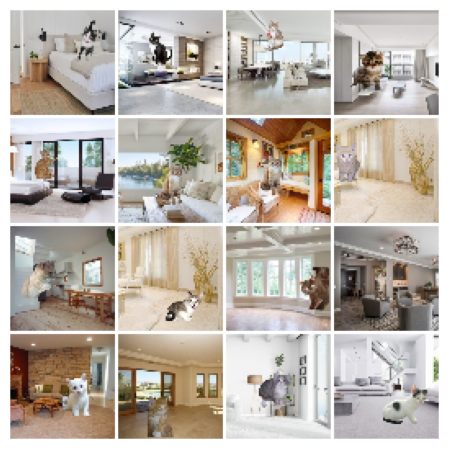

In [0]:
image_show(bg_fg_i[:16], figsize = (8,8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


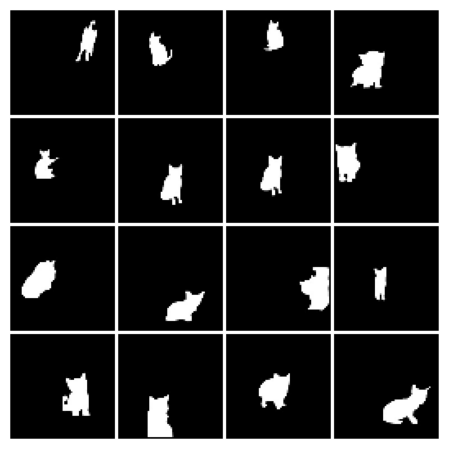

In [0]:
image_show(mask_i[:16], figsize = (8,8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


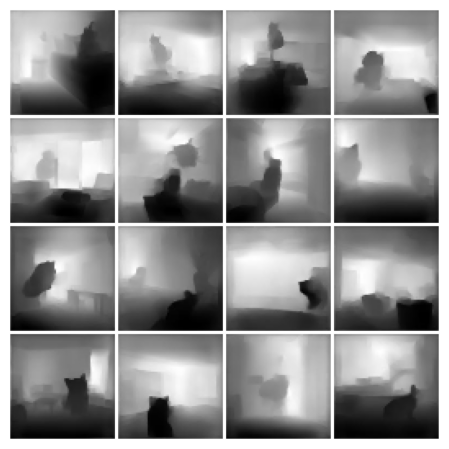

In [0]:
image_show(depth_i[:16], figsize = (8,8))

## Model setup and Summary

In [0]:
model = DepthMaskNet()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.to(device)
summary(model, [(3,192,192), (3,192,192)])

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 192, 192]             864
       BatchNorm2d-2         [-1, 32, 192, 192]              64
              ReLU-3         [-1, 32, 192, 192]               0
            Conv2d-4         [-1, 32, 192, 192]             864
       BatchNorm2d-5         [-1, 32, 192, 192]              64
              ReLU-6         [-1, 32, 192, 192]               0
            Conv2d-7         [-1, 32, 192, 192]           2,048
            Conv2d-8         [-1, 64, 192, 192]          18,432
       BatchNorm2d-9         [-1, 64, 192, 192]             128
             ReLU-10         [-1, 64, 192, 192]               0
           Conv2d-11         [-1, 64, 192, 192]          18,432
             ReLU-12         [-1, 64, 192, 192]               0
      BatchNorm2d-13         [-1, 64, 192, 192]             128
           Conv2d-14         [-1, 

## Model Training and validation

### Loss functions

In [0]:
criterion_l1 = nn.L1Loss()
criterion_ssim = SSIM(3, reduction='mean')
criterion_diceBCE = loss.DiceBCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.01)

In [0]:
train_metrics = {"epoch_train_loss":[], "epoch_mask_mean_abs_error": [],"epoch_mask_dice_coeff":[], "epoch_mask_rms_error":[], 
      "epoch_depth_mean_abs_error":[], "epoch_depth_dice_coeff":[], "epoch_depth_rms_error":[]}
test_metrics = {"epoch_test_loss":[], "epoch_mask_mean_abs_error": [],"epoch_mask_dice_coeff":[], "epoch_mask_rms_error":[], 
      "epoch_depth_mean_abs_error":[], "epoch_depth_dice_coeff":[], "epoch_depth_rms_error":[]} 

### Model Run

In [0]:
for epoch in range(1,4):
    train(model, criterion_l1, criterion_ssim, criterion_diceBCE, device, train_loader, optimizer, epoch, train_metrics, save_model=True)
    test(model, criterion_l1, criterion_ssim, criterion_diceBCE, device, test_loader, epoch, test_metrics)
    scheduler.step()

Mask stats:
Mean absolute error=2.24%	Dice Coefficient=0.81	RMSE error=11.90%
Depth stats:
Mean absolute error=20.85%	Dice Coefficient=0.58	RMSE error=25.27%
Processing time
DataLoad=0.03s, Prediction=0.04s, Loss calculate=0.17s, Backprop=0.01s, Parameter Update=0.01s, Metrics=0.37s
Mask stats:
Mean absolute error=1.77%	Dice Coefficient=0.85	RMSE error=10.60%
Depth stats:
Mean absolute error=20.63%	Dice Coefficient=0.58	RMSE error=25.03%
Processing time
DataLoad=0.01s, Prediction=1.53s, Loss calculate=0.03s, Backprop=3.54s, Parameter Update=0.00s, Metrics=0.02s

Mask stats:
Mean absolute error=1.77%	Dice Coefficient=0.85	RMSE error=10.55%
Depth stats:
Mean absolute error=20.07%	Dice Coefficient=0.58	RMSE error=24.49%
Mask stats:
Mean absolute error=1.77%	Dice Coefficient=0.85	RMSE error=10.52%
Depth stats:
Mean absolute error=20.29%	Dice Coefficient=0.58	RMSE error=24.69%


Mask stats:
Mean absolute error=1.54%	Dice Coefficient=0.87	RMSE error=9.86%
Depth stats:
Mean absolute error=20.29%	Dice Coefficient=0.58	RMSE error=24.68%
Processing time
DataLoad=0.06s, Prediction=0.06s, Loss calculate=0.13s, Backprop=0.02s, Parameter Update=0.00s, Metrics=0.35s
Mask stats:
Mean absolute error=1.40%	Dice Coefficient=0.88	RMSE error=9.40%
Depth stats:
Mean absolute error=19.83%	Dice Coefficient=0.59	RMSE error=24.27%
Processing time
DataLoad=0.01s, Prediction=0.01s, Loss calculate=0.14s, Backprop=0.01s, Parameter Update=0.00s, Metrics=0.32s

Mask stats:
Mean absolute error=1.42%	Dice Coefficient=0.88	RMSE error=9.38%
Depth stats:
Mean absolute error=20.35%	Dice Coefficient=0.58	RMSE error=24.72%
Mask stats:
Mean absolute error=1.38%	Dice Coefficient=0.88	RMSE error=9.25%
Depth stats:
Mean absolute error=20.01%	Dice Coefficient=0.58	RMSE error=24.52%


Mask stats:
Mean absolute error=1.39%	Dice Coefficient=0.88	RMSE error=9.33%
Depth stats:
Mean absolute error=20.06%	Dice Coefficient=0.58	RMSE error=24.40%
Processing time
DataLoad=0.02s, Prediction=0.06s, Loss calculate=0.13s, Backprop=0.02s, Parameter Update=0.01s, Metrics=0.34s
Mask stats:
Mean absolute error=1.38%	Dice Coefficient=0.88	RMSE error=9.28%
Depth stats:
Mean absolute error=20.04%	Dice Coefficient=0.59	RMSE error=24.49%
Processing time
DataLoad=0.01s, Prediction=0.01s, Loss calculate=0.14s, Backprop=0.01s, Parameter Update=0.00s, Metrics=0.31s

Mask stats:
Mean absolute error=1.38%	Dice Coefficient=0.88	RMSE error=9.27%
Depth stats:
Mean absolute error=20.24%	Dice Coefficient=0.58	RMSE error=24.62%
Mask stats:
Mean absolute error=1.42%	Dice Coefficient=0.88	RMSE error=9.41%
Depth stats:
Mean absolute error=20.75%	Dice Coefficient=0.58	RMSE error=25.13%


In [0]:
print(train_metrics)
print(test_metrics)

{'epoch_train_loss': [1.8789357515750027, 1.4130323780955953, 1.3833680111485818], 'epoch_mask_mean_abs_error': [0.10166648449120835, 0.015312110865573778, 0.013883592778820224], 'epoch_mask_dice_coeff': [0.6530842277641924, 0.8691579204808642, 0.8805193479361874], 'epoch_mask_rms_error': [0.18372844543709835, 0.09808301993763208, 0.09322542042030495], 'epoch_depth_mean_abs_error': [0.21023984931722636, 0.2026429978323593, 0.20199254866165042], 'epoch_depth_dice_coeff': [0.5748262242490674, 0.582140168389629, 0.5825546650825515], 'epoch_depth_rms_error': [0.254970851447944, 0.2469276435250992, 0.24619194039805933]}
{'epoch_test_loss': [1.45377166879938, 1.388459727104674, 1.383931484628231], 'epoch_mask_mean_abs_error': [0.017594182269370304, 0.014067779909423057, 0.013919987767300707], 'epoch_mask_dice_coeff': [0.8528261217665165, 0.8788333235902989, 0.8800678940529519], 'epoch_mask_rms_error': [0.10496661891328528, 0.09344937569917516, 0.09340701534392985], 'epoch_depth_mean_abs_erro

## Transfer Model dictionary 

In [0]:
!zip -r -q model_save_112.zip model_save/

In [0]:
shutil.move("model_save_112.zip", gdrive_path)

'/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth/model_save_112.zip'

## Train with image size 112 x 112

In [0]:
train_dataset = schrodingersCatDataset(data_root, train=True, train_split=0.7, transform=True, target_transform=True, resize=(112,112))
test_dataset = schrodingersCatDataset(data_root, train=False, train_split=0.7, transform=True, target_transform=True, resize=(112,112))

params = {'batch_size': 128, 'shuffle': True, 'num_workers': 12, 'pin_memory':True}

train_loader = DataLoader(train_dataset, **params)
test_loader = DataLoader(test_dataset, **params)

input transforms applied
input transforms applied
target transforms applied
target transforms applied
input transforms applied
input transforms applied
target transforms applied
target transforms applied


In [0]:
criterion_l1 = nn.L1Loss()
criterion_ssim = SSIM(3, reduction='mean')
criterion_diceBCE = loss.DiceBCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.01)

In [0]:
for epoch in range(1,4):
    train(model, criterion_l1, criterion_ssim, criterion_diceBCE, device, train_loader, optimizer, epoch, train_metrics, save_model=True)
    test(model, criterion_l1, criterion_ssim, criterion_diceBCE, device, test_loader, epoch, test_metrics)
    scheduler.step()

Mask stats:
Mean absolute error=0.67%	Dice Coefficient=0.93	RMSE error=5.99%
Depth stats:
Mean absolute error=20.28%	Dice Coefficient=0.58	RMSE error=24.65%
Processing time
DataLoad=0.02s, Prediction=0.06s, Loss calculate=0.10s, Backprop=0.04s, Parameter Update=0.01s, Metrics=0.24s
Mask stats:
Mean absolute error=0.59%	Dice Coefficient=0.94	RMSE error=5.44%
Depth stats:
Mean absolute error=19.78%	Dice Coefficient=0.59	RMSE error=24.21%
Processing time
DataLoad=0.00s, Prediction=0.52s, Loss calculate=0.01s, Backprop=1.36s, Parameter Update=0.00s, Metrics=0.00s

Mask stats:
Mean absolute error=0.61%	Dice Coefficient=0.93	RMSE error=5.58%
Depth stats:
Mean absolute error=20.63%	Dice Coefficient=0.57	RMSE error=25.03%
Mask stats:
Mean absolute error=0.57%	Dice Coefficient=0.94	RMSE error=5.33%
Depth stats:
Mean absolute error=19.52%	Dice Coefficient=0.60	RMSE error=23.70%


Mask stats:
Mean absolute error=0.58%	Dice Coefficient=0.94	RMSE error=5.44%
Depth stats:
Mean absolute error=20.13%	Dice Coefficient=0.58	RMSE error=24.51%
Processing time
DataLoad=0.01s, Prediction=0.03s, Loss calculate=0.12s, Backprop=0.01s, Parameter Update=0.01s, Metrics=0.26s
Mask stats:
Mean absolute error=0.61%	Dice Coefficient=0.94	RMSE error=5.57%
Depth stats:
Mean absolute error=20.23%	Dice Coefficient=0.59	RMSE error=24.67%
Processing time
DataLoad=0.00s, Prediction=0.01s, Loss calculate=0.06s, Backprop=0.01s, Parameter Update=0.00s, Metrics=0.13s

Mask stats:
Mean absolute error=0.61%	Dice Coefficient=0.94	RMSE error=5.60%
Depth stats:
Mean absolute error=21.13%	Dice Coefficient=0.58	RMSE error=25.46%
Mask stats:
Mean absolute error=0.59%	Dice Coefficient=0.94	RMSE error=5.48%
Depth stats:
Mean absolute error=20.81%	Dice Coefficient=0.57	RMSE error=25.30%


Mask stats:
Mean absolute error=0.58%	Dice Coefficient=0.94	RMSE error=5.35%
Depth stats:
Mean absolute error=19.86%	Dice Coefficient=0.59	RMSE error=24.32%
Processing time
DataLoad=0.01s, Prediction=0.04s, Loss calculate=0.11s, Backprop=0.02s, Parameter Update=0.00s, Metrics=0.25s
Mask stats:
Mean absolute error=0.58%	Dice Coefficient=0.94	RMSE error=5.34%
Depth stats:
Mean absolute error=19.94%	Dice Coefficient=0.58	RMSE error=24.40%
Processing time
DataLoad=0.00s, Prediction=0.01s, Loss calculate=0.06s, Backprop=0.01s, Parameter Update=0.00s, Metrics=0.13s

Mask stats:
Mean absolute error=0.61%	Dice Coefficient=0.94	RMSE error=5.60%
Depth stats:
Mean absolute error=20.42%	Dice Coefficient=0.58	RMSE error=24.92%
Mask stats:
Mean absolute error=0.59%	Dice Coefficient=0.94	RMSE error=5.43%
Depth stats:
Mean absolute error=19.98%	Dice Coefficient=0.58	RMSE error=24.44%


In [0]:
print(train_metrics)
print(test_metrics)

{'epoch_train_loss': [1.8789357515750027, 1.4130323780955953, 1.3833680111485818, 1.3104182043720642, 1.272764168557127, 1.2722133538622742], 'epoch_mask_mean_abs_error': [0.10166648449120835, 0.015312110865573778, 0.013883592778820224, 0.007194290348154985, 0.006001312254589235, 0.005991603459582291], 'epoch_mask_dice_coeff': [0.6530842277641924, 0.8691579204808642, 0.8805193479361874, 0.9294975355294767, 0.9389414356057779, 0.9390024339858531], 'epoch_mask_rms_error': [0.18372844543709835, 0.09808301993763208, 0.09322542042030495, 0.06198464556711247, 0.05525492841864798, 0.05517270926631292], 'epoch_depth_mean_abs_error': [0.21023984931722636, 0.2026429978323593, 0.20199254866165042, 0.20234087328860703, 0.20105813294512917, 0.20105131336877724], 'epoch_depth_dice_coeff': [0.5748262242490674, 0.582140168389629, 0.5825546650825515, 0.5819369214271932, 0.5826907926383794, 0.5827001222090922], 'epoch_depth_rms_error': [0.254970851447944, 0.2469276435250992, 0.24619194039805933, 0.24656

## Training with Image size 192 x 192

In [0]:
train_dataset = schrodingersCatDataset(data_root, train=True, train_split=0.7, transform=True, target_transform=True, resize=(192,192))
test_dataset = schrodingersCatDataset(data_root, train=False, train_split=0.7, transform=True, target_transform=True, resize=(192,192))

params = {'batch_size': 32, 'shuffle': True, 'num_workers': 12, 'pin_memory':True}

train_loader = DataLoader(train_dataset, **params)
test_loader = DataLoader(test_dataset, **params)

input transforms applied
input transforms applied
target transforms applied
target transforms applied
input transforms applied
input transforms applied
target transforms applied
target transforms applied


In [0]:
for epoch in range(1,2):
    train(model, criterion_l1, criterion_ssim, criterion_diceBCE, device, train_loader, optimizer, epoch, train_metrics, save_model=True)
    test(model, criterion_l1, criterion_ssim, criterion_diceBCE, device, test_loader, epoch, test_metrics)
    scheduler.step()

Mask stats:
Mean absolute error=0.30%	Dice Coefficient=0.97	RMSE error=3.66%
Depth stats:
Mean absolute error=21.13%	Dice Coefficient=0.58	RMSE error=25.46%
Processing time
DataLoad=0.01s, Prediction=0.02s, Loss calculate=0.08s, Backprop=0.01s, Parameter Update=0.00s, Metrics=0.20s
Mask stats:
Mean absolute error=0.26%	Dice Coefficient=0.97	RMSE error=3.35%
Depth stats:
Mean absolute error=19.38%	Dice Coefficient=0.58	RMSE error=23.70%
Processing time
DataLoad=0.01s, Prediction=0.01s, Loss calculate=0.09s, Backprop=0.00s, Parameter Update=0.00s, Metrics=0.20s

Mask stats:
Mean absolute error=0.24%	Dice Coefficient=0.98	RMSE error=3.16%
Depth stats:
Mean absolute error=19.31%	Dice Coefficient=0.59	RMSE error=23.81%
Mask stats:
Mean absolute error=0.27%	Dice Coefficient=0.97	RMSE error=3.44%
Depth stats:
Mean absolute error=19.90%	Dice Coefficient=0.59	RMSE error=24.11%


## Results

In [0]:
print(train_metrics)
print(test_metrics)

{'epoch_train_loss': [1.8789357515750027, 1.4130323780955953, 1.3833680111485818, 1.3104182043720642, 1.272764168557127, 1.2722133538622742, 1.4358197920663016, 1.246076325416565], 'epoch_mask_mean_abs_error': [0.10166648449120835, 0.015312110865573778, 0.013883592778820224, 0.007194290348154985, 0.006001312254589235, 0.005991603459582291, 0.003881429378369025, 0.003124488087158118], 'epoch_mask_dice_coeff': [0.6530842277641924, 0.8691579204808642, 0.8805193479361874, 0.9294975355294767, 0.9389414356057779, 0.9390024339858531, 0.9614480233601161, 0.9672638589177813], 'epoch_mask_rms_error': [0.18372844543709835, 0.09808301993763208, 0.09322542042030495, 0.06198464556711247, 0.05525492841864798, 0.05517270926631292, 0.044353413729156764, 0.03780076758733818], 'epoch_depth_mean_abs_error': [0.21023984931722636, 0.2026429978323593, 0.20199254866165042, 0.20234087328860703, 0.20105813294512917, 0.20105131336877724, 0.2179549435853958, 0.2018305710213525], 'epoch_depth_dice_coeff': [0.57482

### Train/Test Loss and Mask Dice Coefficient graph

Shared below are the graphs for Loss, Dice Coefficient, Mean Absolute error, Root Mean Square error for Mask and Depth images during train and test.

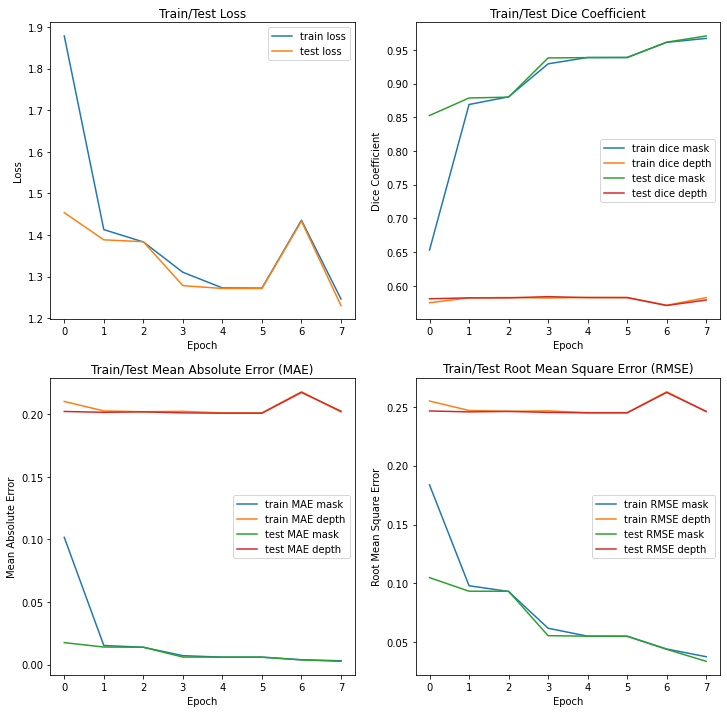

In [0]:
loss_dice_MEA_RMS_metrics_graph(train_metrics, test_metrics)
